### Single cell model

Consider a 1-D chain of bursting neurons coupled to a single inhibitory cell. The governing equations for the dynamics of each individual cell are:

$$ \dot{V}(t) = -\frac{V(t)}{\tau_m} + \frac{I(t)}{C}$$

where $V(t)$ is the membrane potential, $\tau_m$ is the membrane time constant, $I(t)$ is the external current, and $C$ is the membrane capacitance.

If neuron 1 is connected to neuron 2 by directional weight $w$, then the spike from 1 elicits current $I_{s}(t)$ in cell 2, where $I_{s}$ is given by:

$$ I_{s}(t) = w \frac{e}{\tau_{\alpha}} (t-t_s) e^{-(t-t_s)/\tau_{\alpha}} \Theta (t - t_s)$$

where $\Theta$ is the Heaviside function.

If neuron 1 fires at a consistent rate $f$, such that $1/f$ is proportional to or less the $\tau_{\alpha}$, the current in cell 2 will saturate at:

$$ I_{f} = w \tau_{\alpha} e f $$

### Chain model

Assume each excitatory cell in the chain is coupled to its successor with weight $W_{ee}$ and that each cell is coupled to the I cell with weight $W_{ei}$. Assume the I cell is coupled to all cells in the chain with weight $W_{ie}$.

If activity in the chain has reached steady (propagating state), then the average drive to the I cell is:

$$ I_{ei} = W_{ei} f_e p t_b $$

where $f_e$ is the burst frequency of the bursting cells, $p$ is the number of cells bursting per second (or the propagation speed), and $t_b$ is the duration of the burst for each bursting cell.

To calculate the average firing rate of the I cell, we begin with the equation for the voltage of a current-coupled neuron driven by a constant current:

$$ V(t) = \frac{1}{C_i}\int_{0}^{t} e^{-(t-t')/\tau_i} I_{ei} dt'$$

$$ V_{th}^{i} = \frac{I_{ei}}{C_i} \tau_i \left(1 - e^{-t/\tau_i}\right) $$

This implies the average time to fire is:

$$ t^*_i = -\tau_i \log \left( 1 - \frac{V_{th}^{i} C_i}{I_{ei} \tau_i} \right) $$

This implies firing rate $f_i$:

$$ f_i = \frac{-1}{\tau_i \log \left( 1 - \frac{V_{th}^{i} C_i}{W_{ei} f_e p t_b \tau_i} \right)} $$

Now we turn to calculating the time-to-fire of a bursting cells that is just beginning to receive input from its predecessor. We assume steady state, so this cell has been receiving constant inhibitory spikes of frequency $f_i$ for a long time. Therefore, we have:

$$ V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e} = \frac{1}{C_e}\int_0^{t^*_e} e^{-(t-t')/\tau_e} W_{ee} f_e dt'$$


$$ V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e} = \frac{\tau_e}{C_e} (1 - e^{-t^*_e/\tau_e} ) W_{ee} f_e$$

Rearranging, this yields:

$$ t^*_e = -\tau_e \log \left(1 - \frac{C_e (V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e})}{\tau_e W_{ee} f_e }\right)$$

This implies:

$$ p_{out} = \frac{-1}{\tau_e \log \left(1 - \frac{C_e (V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e})}{\tau_e W_{ee} f_e }\right) }$$

where $f_i$ is a function of $p$.

We then write:
    
$$ p_{out} = p + \Delta p $$

This yields:

$$ p + \Delta p = \frac{-1}{\tau_e \log \left(1 - \frac{C_e (V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e})}{\tau_e W_{ee} f_e }\right) }$$

$$ \Delta p = \frac{-1}{ \tau_e \log \left(1 - \frac{C_e (V_{th}^{e} - \frac{W_{ie} f_i \tau_e}{C_e})}{\tau_e W_{ee} f_e }\right)} - p$$

We set $\Delta p = 0$ to find fixed points. 

### Calculation of stable values of p for different values of recurrent inhibition

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
from ntwk import LIFNtwkI
from aux import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from functools import partial

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
dt = 5e-5
tau_m_e = 4e-3
tau_m_i = 4e-3
tau_a = 3e-3
v_th_e = 20e-3
v_th_i = 20e-3
c_e = 1e-6
c_i = 1e-6

w_ee = 2.4e-4
w_ei = 1.5e-5
w_ie = -1.5e-5

In [3]:
def f_i(input_current):
    x = v_th_i * c_i / (tau_m_i * input_current)
    return np.where(x >= 0, np.where(x >= 1, 0, -1 / (tau_m_i * np.log(1 - x))), 0)

def v_a_transient(t):
    m = (1 / tau_a - 1/ tau_m_e)
    x = (np.exp(-t/tau_m_e) - np.exp(-t/tau_a)) / np.square(m) - t * np.exp(-t/tau_a) / m
    return np.where(t >= 0, np.e / (c_e * tau_a) * x, 0)

def dp(p, w_ei, w_ie):
#     print()
#     print('transient:', c_e * w_ee * v_a_transient(1/p))
#     print('thresh:', -(c_e * v_th_e))
#     print('f_i:', f_i(w_ei * tau_a * np.e * p))
    return c_e * w_ee * v_a_transient(1/p) - c_e * v_th_e + tau_m_e * w_ie * tau_a * np.e * f_i(w_ei * tau_a * np.e * p)

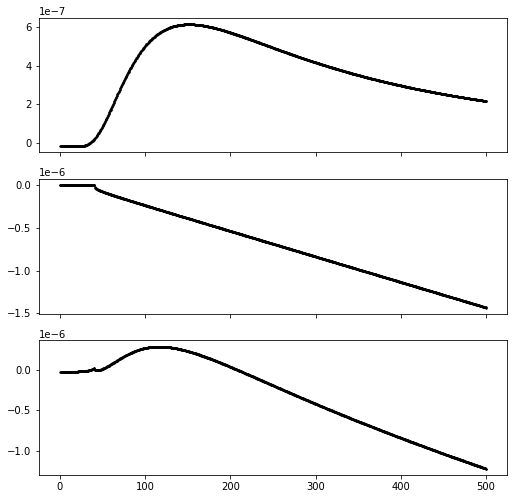

In [4]:
scale = 1.4
fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(6 * scale, 6 * scale))

p = np.linspace(0, 500, 1000)
axs[0].scatter(p, c_e * w_ee * v_a_transient(1/p) - (c_e * v_th_e), s=2, c='black')
axs[1].scatter(p, tau_m_e * w_ie * tau_a * np.e * f_i(w_ei * tau_a * np.e * p), s=2, c='black')
axs[2].scatter(p, dp(p), s=2, c='black')

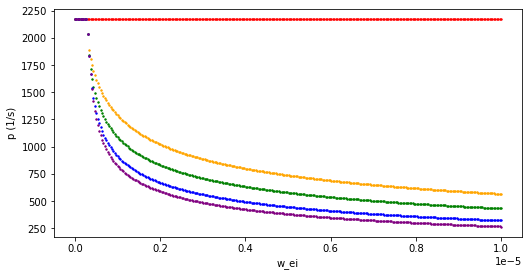

In [35]:
scale = 1.4
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6 * scale, 3 * scale))
colors = ['red', 'orange', 'green', 'blue', 'purple']

data = []

for j, w_ie in enumerate([0, -0.25e-5, -0.5e-5, -1e-5, -1.5e-5]):
    for i, w_ei in enumerate(np.linspace(0, 1e-5, 300)):
        p_stable = fsolve(dp, 300)
    #     print()
    #     print('FINISH')
    #     print(p_stable)
    #     print(dp(p_stable))
        x = [w_ei] * len(p_stable)
        axs.scatter(x, p_stable, c=colors[j], s=2)
        axs.set_ylabel('p (1/s)')
        axs.set_xlabel(r'w_ei')
        
        data.append((w_ie, x, p_stable))
    #     axs[i].plot(p, [0] * len(p), '--', c='red')
    #     axs[i].set_xlim(0, 5000)
    #     axs[i].legend()
    #     axs[1].scatter([w_ei] * len(p_stable), tau_m_e * w_ie * tau_a * np.e * f_i(w_ei * tau_a * np.e * p_stable), c='green', s=2)    
    #     axs[1].scatter([w_ei] * len(p_stable), c_e * w_ee * v_a_transient(1/p_stable) - c_e * v_th_e, c='red', s=2)
    # #     axs[1].set_ylabel('f_i (1/s)')
    #     axs[1].set_xlabel(r'w_ei')

In [30]:
# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.25e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.07,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=20e-3,  # refractory period (s)
    T_R_I=0,
    E_R_E=-0.07, # reset voltage (V)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    N_EXC=800,
    N_INH=1,
    
    # OTHER INPUTS
    SGM_N=.1e-10,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
    
    W_E_E = 2.4e-5,
    W_E_I = 0, #0.2e-5, #1e-5,
    W_I_E = -0.18e-5,
    W_U_E = 0.2e-4,
    W_U_I = 0.05e-5, #1e-1,
    
    F_B = 5e3,
    T_B = 10e-3,
)

t_r = M.T_R_E * np.ones((M.N_EXC + M.N_INH))
t_r[-1] = M.T_R_I

In [36]:
np.random.seed(2001)

def speed_test(M, buffer=300):
    w_r = np.block([
        [ M.W_E_E * np.diag(np.ones((M.N_EXC - 1)), k=-1), M.W_I_E * np.ones((M.N_EXC, M.N_INH)) ],
        [ M.W_E_I * np.ones((M.N_INH, M.N_EXC)), np.zeros((M.N_INH, M.N_INH)) ],
    ])

    w_u = np.block([
        [ np.array([M.W_U_E]), np.zeros((1)) ],
        [ np.zeros((M.N_EXC - 1, 2)) ],
        [ np.zeros((M.N_INH, 1)), M.W_U_I * np.ones((M.N_INH, 1)) ],
    ])

    i_b = np.zeros((M.N_EXC + M.N_INH), dtype=int)

    ntwk = LIFNtwkI(
        c_m = M.C_M_E,
        g_l = M.G_L_E,
        e_l = M.E_L_E,
        v_th = M.V_TH_E,
        v_r = M.E_R_E,
        t_r = t_r,
        w_r = w_r,
        w_u = w_u,
        i_b = i_b,
        f_b = M.F_B,
        t_b = M.T_B,
        t_a = 3e-3,
    )

    S = Generic(RNG_SEED=0, T=0.2, DT=dt)
    t = np.arange(0, S.T, S.DT)

    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[0, 0] = 1

    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: M.E_L_E * np.ones((M.N_EXC + M.N_INH))}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)

    raster = np.stack([rsp.spks_t, rsp.spks_c])
    inh_raster = raster[:, raster[1, :] >= M.N_EXC]
    exc_raster = raster[:, raster[1, :] < M.N_EXC]
    
    parsed_exc_raster = exc_raster[:, exc_raster[0, :] >= buffer * S.DT]
    try:
        res = stats.linregress(parsed_exc_raster[0, :], parsed_exc_raster[1, :])
    except ValueError as e:
        print(e)
        return (np.nan, parsed_exc_raster)
    
    return res.slope, parsed_exc_raster

In [38]:
data = []

w_ie_vals = [0, -0.25e-5, -0.5e-5, -1e-5, -1.5e-5]
w_ei_vals = np.linspace(0, 1e-5, 50)

for j, w_ie in enumerate(w_ie_vals):
    all_p = []
    rasters = []
    for i, w_ei in enumerate(w_ei_vals):
        m = copy(M)
        m.W_E_E = w_ee
        m.W_E_I = w_ei
        m.W_I_E = w_ie
        p_stable, parsed_raster = speed_test(m)
        all_p.append(p_stable)
        rasters.append(parsed_raster)
        print(f'w_ie {w_ie}, w_ei: {w_ei}, p: {p_stable}')
    data.append((w_ie, w_ei_vals, all_p, rasters))

# plt.show()

w_ie 0, w_ei: 0.0, p: 2000.0000000000002
w_ie 0, w_ei: 2.0408163265306124e-07, p: 2000.0000000000002
w_ie 0, w_ei: 4.081632653061225e-07, p: 2000.0000000000002
w_ie 0, w_ei: 6.122448979591837e-07, p: 2000.0000000000002
w_ie 0, w_ei: 8.16326530612245e-07, p: 2000.0000000000002
w_ie 0, w_ei: 1.0204081632653063e-06, p: 2000.0000000000002
w_ie 0, w_ei: 1.2244897959183673e-06, p: 2000.0000000000002
w_ie 0, w_ei: 1.4285714285714286e-06, p: 2000.0000000000002
w_ie 0, w_ei: 1.63265306122449e-06, p: 2000.0000000000002
w_ie 0, w_ei: 1.8367346938775512e-06, p: 2000.0000000000002
w_ie 0, w_ei: 2.0408163265306125e-06, p: 2000.0000000000002
w_ie 0, w_ei: 2.244897959183674e-06, p: 2000.0000000000002
w_ie 0, w_ei: 2.4489795918367347e-06, p: 2000.0000000000002
w_ie 0, w_ei: 2.653061224489796e-06, p: 2000.0000000000002
w_ie 0, w_ei: 2.8571428571428573e-06, p: 2000.0000000000002
w_ie 0, w_ei: 3.0612244897959185e-06, p: 2000.0000000000002
w_ie 0, w_ei: 3.26530612244898e-06, p: 2000.0000000000002
w_ie 0, w

w_ie -5e-06, w_ei: 6.734693877551021e-06, p: 511.2484002162304
w_ie -5e-06, w_ei: 6.938775510204082e-06, p: 504.76190611415063
w_ie -5e-06, w_ei: 7.1428571428571436e-06, p: 498.9530859902022
w_ie -5e-06, w_ei: 7.346938775510205e-06, p: 491.6401968938809
w_ie -5e-06, w_ei: 7.551020408163266e-06, p: 487.1735190917071
w_ie -5e-06, w_ei: 7.755102040816327e-06, p: 482.7085089486624
w_ie -5e-06, w_ei: 7.959183673469388e-06, p: 475.87300473608235
w_ie -5e-06, w_ei: 8.16326530612245e-06, p: 472.1039941996711
w_ie -5e-06, w_ei: 8.36734693877551e-06, p: 466.27862161531186
w_ie -5e-06, w_ei: 8.571428571428573e-06, p: 464.3331724091006
w_ie -5e-06, w_ei: 8.775510204081633e-06, p: 458.3016833116459
w_ie -5e-06, w_ei: 8.979591836734695e-06, p: 453.74162648156783
w_ie -5e-06, w_ei: 9.183673469387756e-06, p: 449.64046172143975
w_ie -5e-06, w_ei: 9.387755102040818e-06, p: 444.3650609805868
w_ie -5e-06, w_ei: 9.591836734693878e-06, p: 443.3881401186838
w_ie -5e-06, w_ei: 9.795918367346939e-06, p: 438.32

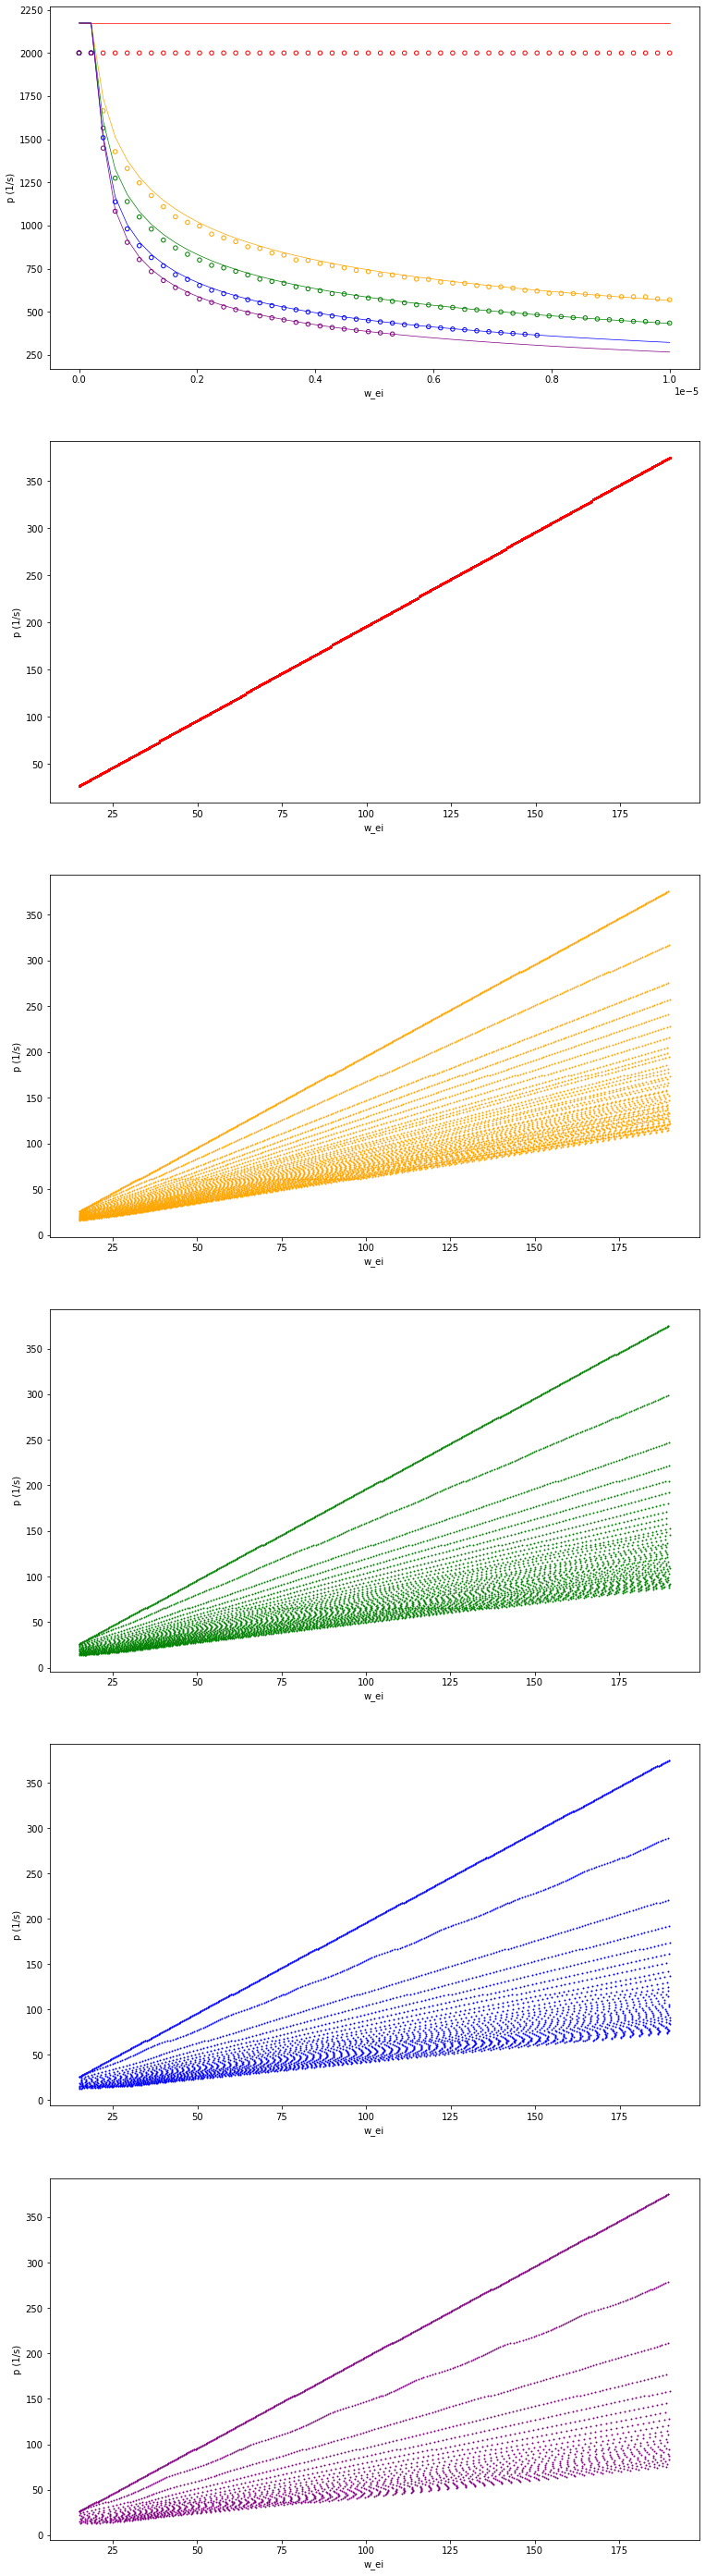

In [46]:
scale = 1.4
n = len(w_ie_vals)
fig, axs = plt.subplots(1 + n, 1, sharex=False, sharey=False, figsize=(9 * scale, 6 * (1 + n) * scale))
colors = ['red', 'orange', 'green', 'blue', 'purple']

for j, (w_ie, w_ei_vals, all_p, rasters) in enumerate(data):
    p_theory = []
    for w_ei in w_ei_vals:
        p_stable = fsolve(dp, 300)
        p_theory.append(p_stable)
    x = [w_ei] * len(p_stable)
    axs[0].plot(w_ei_vals, p_theory, color=colors[j], lw=0.7)
    axs[0].scatter(w_ei_vals, all_p, color=colors[j], facecolor='none', s=20, alpha=1.0)
    for raster in rasters:
        axs[1 + j].scatter(raster[0, :] * 1000, raster[1, :], c=colors[j], s=1)
for i in range(1 + n):
    axs[i].set_ylabel('p (1/s)')
    axs[i].set_xlabel(r'w_ei')

### Controling p with uva input

Now, supply the I cell with an additional excitatory input $u$. The equation for $f_i$ is now:

$$ f_i = \frac{-1}{\tau_i \log \left( 1 - \frac{V_{th}^{i} C_i}{\tau_i (W_{ei} f_e p t_b + u)} \right)} $$

This provides a means for controlling the propagation speed of the E cells.

NameError: name 'w_ie_base' is not defined

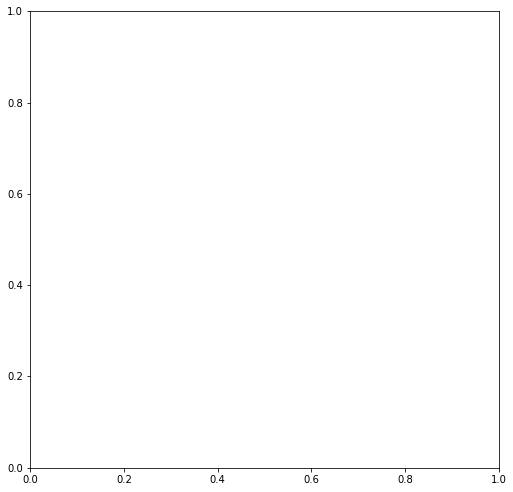

In [9]:
scale = 1.4
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6 * scale, 6 * scale))

w_ie = w_ie_base

colors = ['purple', 'blue', 'orange']

for i, u in enumerate([0, 0.5e-1 * dt, 2e-1 * dt]):
    p = np.linspace(10, 2000, 1000)
    axs.plot(p, dp(p, u), lw=1., label=f'u={u}', c=colors[i])
axs.set_xlabel('p (1/s)')
axs.set_ylabel(r'$\Delta p$ (1/s)')
axs.plot(p, [0] * len(p), '--', c='red')
axs.set_xlim(0, 2000)
axs.legend()
plt.show()

### Why bother with the recurrent inhibitory loop?

Uva could just as easily directly inhibit or excite the chain itself. However, a chain without recurrent inhibition changes propagation speed when E cells die. To explore this, we modulate $W_{ei}$ and $W_{ee}$ by a factor $\alpha$ to explore the effect of hypothetical E cell death.

### Propagation speed fixed points of a chain for different values of $\alpha$ and Uva input )

#### 1. With recurrent inhibition and Uva exciting the I cell:

In [ ]:
scale = 1.4
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6 * scale, 6 * scale))

w_ie = w_ie_base

colors = ['purple', 'blue']

for i, u in enumerate([0, 1e-1 * dt * tau_e * 1200]):
    for j, alpha in enumerate([1, 0.9, 0.8, 0.7, 0.6]):
        p = np.linspace(10, 2500, 1000)
        line, = axs.plot(p, dp(p, u, alpha), lw=1., dashes = ([2 * j + 1] * 4), label=f'u={u}, alpha={alpha}', c=colors[i])
axs.set_xlabel('p (1/s)')
axs.set_ylabel(r'$\Delta p$ (1/s)')
axs.plot(p, [0] * len(p), '--', c='red')
axs.set_xlim(0, 1000)
axs.set_ylim(-100, 100)
axs.legend()
plt.show()

Here we see that the effect of the uva input is roughly preserved after we rescale $W_{ee}$ and $W_{ei}$ by $\alpha$: the additional input roughly halves the propagation speed.

#### 2. Without recurrent inhibition and direct inhibition of chain from Uva:

In [ ]:
scale = 1.4
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6 * scale, 6 * scale))

w_ie = 0

colors = ['purple', 'blue']

for i, u_e in enumerate([0, 2e-1 * dt]):
    for j, alpha in enumerate([1, 0.9, 0.8, 0.7, 0.6]):
        p = np.linspace(10, 5000, 1000)
        axs.plot(p, dp(p, 0, alpha, u_e=u_e), lw=1., dashes=([2 * j + 1] * 4), label=f'u_e={u_e}, alpha={alpha}', c=colors[i])
axs.set_xlabel('p (1/s)')
axs.set_ylabel(r'$\Delta p$ (1/s)')
axs.plot(p, [0] * len(p), '--', c='red')
# axs.set_xlim(0, 1000)
axs.set_ylim(-100, 100)
axs.legend()
plt.show()

Here, we see that the effect of the uva input is not preserved after rescaling by alpha.

In [ ]:
# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.25e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.07,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=10e-3,  # refractory period (s)
    T_R_I=0,
    E_R_E=-0.07, # reset voltage (V)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    N_EXC=800,
    N_INH=1,
    
    # OTHER INPUTS
    SGM_N=.1e-10,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
    
    W_E_E = 2.4e-5,
    W_E_I = 0, #0.2e-5, #1e-5,
    W_I_E = -0.18e-5,
    W_U_E = 0.2e-4,
    W_U_I = 0.05e-5, #1e-1,
    
    F_B = 5e3,
    T_B = 10e-3,
)

t_r = M.T_R_E * np.ones((M.N_EXC + M.N_INH))
t_r[-1] = M.T_R_I

In [ ]:
np.random.seed(2001)

w_r = np.block([
    [ M.W_E_E * np.diag(np.ones((M.N_EXC - 1)), k=-1), M.W_I_E * np.ones((M.N_EXC, M.N_INH)) ],
    [ M.W_E_I * np.ones((M.N_INH, M.N_EXC)), np.zeros((M.N_INH, M.N_INH)) ],
])

w_u = np.block([
    [ np.array([M.W_U_E]), np.zeros((1)) ],
    [ np.zeros((M.N_EXC - 1, 2)) ],
    [ np.zeros((M.N_INH, 1)), M.W_U_I * np.ones((M.N_INH, 1)) ],
])

i_b = np.zeros((M.N_EXC + M.N_INH), dtype=int)

ntwk = LIFNtwkI(
    c_m = M.C_M_E,
    g_l = M.G_L_E,
    e_l = M.E_L_E,
    v_th = M.V_TH_E,
    v_r = M.E_R_E,
    t_r = t_r,
    w_r = w_r,
    w_u = w_u,
    i_b = i_b,
    f_b = M.F_B,
    t_b = M.T_B,
    t_a = 4e-3,
)

S = Generic(RNG_SEED=0, DT=dt)
t = np.arange(0, 2.5, S.DT)

spks_u = np.zeros((len(t), 2), dtype=int)
spks_u[0, 0] = 1
switches = 12
seg_length = int(len(t) / switches)
for i in range(switches):
    if i % 2 == 0:
        spks_u[i * seg_length: (i + 1) * seg_length, 1] = np.random.poisson(lam=2000 * S.DT, size=seg_length)

rsp = ntwk.run(
    dt=S.DT,
    clamp=Generic(v={0: M.E_L_E * np.ones((M.N_EXC + M.N_INH))}, spk={}),
    i_ext=np.zeros(len(t)),
    spks_u=spks_u)

raster = np.stack([rsp.spks_t, rsp.spks_c])
inh_raster = raster[:, raster[1, :] >= M.N_EXC]
exc_raster = raster[:, raster[1, :] < M.N_EXC]

scale = 1.
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(6 * scale, 5 * scale), tight_layout=True)
axs = [fig.add_subplot(gs[0])]

axs[0].scatter(exc_raster[0, :] * 1000, exc_raster[1, :], c='black', s=1)
axs[0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], c='red', s=1)

# axs[0].set_ylim(-1, 102)

scale = 1.
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(6 * scale, 5 * scale), tight_layout=True)
axs = [fig.add_subplot(gs[0])]

buffer = 300
for i in range(switches):
    switch_range = ((i * seg_length + buffer) * S.DT, ((i+1) * seg_length - buffer) * S.DT)
    raster_for_switch = exc_raster[:, (exc_raster[0, :] >= switch_range[0]) & (exc_raster[0, :] < switch_range[1])]
    if i % 2 == 0:
        c = 'purple'
    else:
        c = 'black'
        
    axs[0].scatter(raster_for_switch[0, :] * 1000, raster_for_switch[1, :], c=c, s=1)
    
    if raster_for_switch.shape[1] > 0:
        res = stats.linregress(raster_for_switch[0, :], raster_for_switch[1, :])
        print(res.slope)

In [ ]:
np.random.seed(2002)

w_r = np.block([
    [ M.W_E_E * np.diag(np.ones((M.N_EXC - 1)), k=-1), M.W_I_E * np.ones((M.N_EXC, M.N_INH)) ],
    [ M.W_E_I * np.ones((M.N_INH, M.N_EXC)), np.zeros((M.N_INH, M.N_INH)) ],
])

w_u = np.block([
    [ np.array([M.W_U_E]), np.zeros((1)) ],
    [ np.zeros((M.N_EXC - 1, 2)) ],
    [ np.zeros((M.N_INH, 1)), M.W_U_I * np.ones((M.N_INH, 1)) ],
])

i_b = np.zeros((M.N_EXC + M.N_INH), dtype=int)

ntwk = LIFNtwkI(
    c_m = M.C_M_E,
    g_l = M.G_L_E,
    e_l = M.E_L_E,
    v_th = M.V_TH_E,
    v_r = M.E_R_E,
    t_r = t_r,
    w_r = w_r,
    w_u = w_u,
    i_b = i_b,
    f_b = M.F_B,
    t_b = M.T_B,
    t_a = 4e-3,
)

S = Generic(RNG_SEED=0, DT=dt)
t = np.arange(0, 2.5, S.DT)

spks_u = np.zeros((len(t), 2), dtype=int)
spks_u[0, 0] = 1
switches = 12
seg_length = int(len(t) / switches)
for i in range(switches):
    if i % 2 == 0:
        spks_u[i * seg_length: (i + 1) * seg_length, 1] = np.random.poisson(lam=2000 * S.DT, size=seg_length)

rsp = ntwk.run(
    dt=S.DT,
    clamp=Generic(v={0: M.E_L_E * np.ones((M.N_EXC + M.N_INH))}, spk={}),
    i_ext=np.zeros(len(t)),
    spks_u=spks_u)

raster = np.stack([rsp.spks_t, rsp.spks_c])
inh_raster = raster[:, raster[1, :] >= M.N_EXC]
exc_raster = raster[:, raster[1, :] < M.N_EXC]

scale = 1.
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(6 * scale, 5 * scale), tight_layout=True)
axs = [fig.add_subplot(gs[0])]

axs[0].scatter(exc_raster[0, :] * 1000, exc_raster[1, :], c='black', s=1)
axs[0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], c='red', s=1)

# axs[0].set_ylim(-1, 102)

scale = 1.
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(6 * scale, 5 * scale), tight_layout=True)
axs = [fig.add_subplot(gs[0])]

buffer = 300
for i in range(switches):
    switch_range = ((i * seg_length + buffer) * S.DT, ((i+1) * seg_length - buffer) * S.DT)
    raster_for_switch = exc_raster[:, (exc_raster[0, :] >= switch_range[0]) & (exc_raster[0, :] < switch_range[1])]
    if i % 2 == 0:
        c = 'purple'
    else:
        c = 'black'
        
    axs[0].scatter(raster_for_switch[0, :] * 1000, raster_for_switch[1, :], c=c, s=1)
    
    if raster_for_switch.shape[1] > 0:
        res = stats.linregress(raster_for_switch[0, :], raster_for_switch[1, :])
        print(res.slope)

In [ ]:
# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.25e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.07,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=10e-3,  # refractory period (s)
    T_R_I=0,
    E_R_E=-0.07, # reset voltage (V)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    N_EXC=800,
    N_INH=1,
    
    # OTHER INPUTS
    SGM_N=.1e-10,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
    
    W_E_E = 2.4e-5,
    W_E_I = 0.05e-5, #0.2e-5, #1e-5,
    W_I_E = -0.18e-5,
    W_U_E = 0.2e-4,
    W_U_I = 0.05e-5, #1e-1,
    
    F_B = 5e3,
    T_B = 10e-3,
)

t_r = M.T_R_E * np.ones((M.N_EXC + M.N_INH))
t_r[-1] = M.T_R_I

In [ ]:
np.random.seed(2002)

w_r = np.block([
    [ M.W_E_E * np.diag(np.ones((M.N_EXC - 1)), k=-1), M.W_I_E * np.ones((M.N_EXC, M.N_INH)) ],
    [ M.W_E_I * np.ones((M.N_INH, M.N_EXC)), np.zeros((M.N_INH, M.N_INH)) ],
])

w_u = np.block([
    [ np.array([M.W_U_E]), np.zeros((1)) ],
    [ np.zeros((M.N_EXC - 1, 2)) ],
    [ np.zeros((M.N_INH, 1)), M.W_U_I * np.ones((M.N_INH, 1)) ],
])

i_b = np.zeros((M.N_EXC + M.N_INH), dtype=int)

ntwk = LIFNtwkI(
    c_m = M.C_M_E,
    g_l = M.G_L_E,
    e_l = M.E_L_E,
    v_th = M.V_TH_E,
    v_r = M.E_R_E,
    t_r = t_r,
    w_r = w_r,
    w_u = w_u,
    i_b = i_b,
    f_b = M.F_B,
    t_b = M.T_B,
    t_a = 4e-3,
)

S = Generic(RNG_SEED=0, DT=dt)
t = np.arange(0, 2.5, S.DT)

spks_u = np.zeros((len(t), 2), dtype=int)
spks_u[0, 0] = 1
switches = 12
seg_length = int(len(t) / switches)
for i in range(switches):
    if i % 2 == 0:
        spks_u[i * seg_length: (i + 1) * seg_length, 1] = np.random.poisson(lam=2000 * S.DT, size=seg_length)

rsp = ntwk.run(
    dt=S.DT,
    clamp=Generic(v={0: M.E_L_E * np.ones((M.N_EXC + M.N_INH))}, spk={}),
    i_ext=np.zeros(len(t)),
    spks_u=spks_u)

raster = np.stack([rsp.spks_t, rsp.spks_c])
inh_raster = raster[:, raster[1, :] >= M.N_EXC]
exc_raster = raster[:, raster[1, :] < M.N_EXC]

scale = 1.
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(6 * scale, 5 * scale), tight_layout=True)
axs = [fig.add_subplot(gs[0])]

axs[0].scatter(exc_raster[0, :] * 1000, exc_raster[1, :], c='black', s=1)
axs[0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], c='red', s=1)

# axs[0].set_ylim(-1, 102)

scale = 1.
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(6 * scale, 5 * scale), tight_layout=True)
axs = [fig.add_subplot(gs[0])]

buffer = 300
for i in range(switches):
    switch_range = ((i * seg_length + buffer) * S.DT, ((i+1) * seg_length - buffer) * S.DT)
    raster_for_switch = exc_raster[:, (exc_raster[0, :] >= switch_range[0]) & (exc_raster[0, :] < switch_range[1])]
    if i % 2 == 0:
        c = 'purple'
    else:
        c = 'black'
        
    axs[0].scatter(raster_for_switch[0, :] * 1000, raster_for_switch[1, :], c=c, s=1)
    
    if raster_for_switch.shape[1] > 0:
        res = stats.linregress(raster_for_switch[0, :], raster_for_switch[1, :])
        print(res.slope)